In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Reuse from previous notebook
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split


In [3]:
# Load the cleaned & feature-engineered dataset from previous step
df = pd.read_csv('cleaned_featured_patient_data.csv')

# Define features and target
X = df.drop(columns=['readmitted_within_30d', 'discharge_notes', 'patient_id'])
y = df['readmitted_within_30d']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [5]:
categorical_features = ['gender', 'race', 'primary_diagnosis', 'discharge_disposition',
                        'insurance_type', 'hospital_unit', 'diagnosis_group']

numerical_features = ['age', 'num_procedures', 'num_medications',
                      'comorbidities_count', 'prior_visits', 'length_of_stay', 'high_medication_flag']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


In [7]:
rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_clf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'num_procedures',
                                                   'num_medications',
                                                   'comorbidities_count',
                                                   'prior_visits',
                                                   'length_of_stay',
                                                   'high_medication_flag']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'race',
                                                   'primary_diagnosis',
                                                   'discharge_disposition',
                                                   'insurance_type',
                                                   'hospital_unit',
                                                   'diagnosis_group'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

Confusion Matrix:
 [[61 36]
 [30 73]]

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.63      0.65        97
           1       0.67      0.71      0.69       103

    accuracy                           0.67       200
   macro avg       0.67      0.67      0.67       200
weighted avg       0.67      0.67      0.67       200

ROC AUC Score: 0.6637473726353719


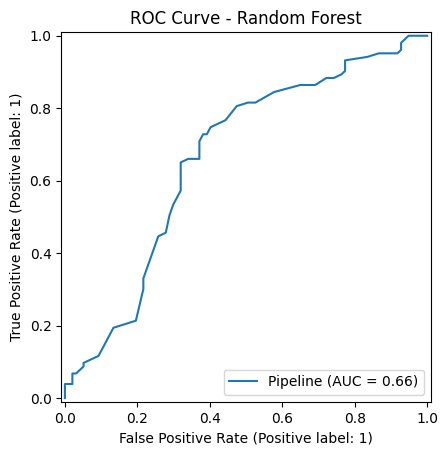

In [9]:
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_rf))

RocCurveDisplay.from_estimator(rf_clf, X_test, y_test)
plt.title("ROC Curve - Random Forest")
plt.show()


In [11]:
# Get encoded categorical feature names
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_features)

# Combine with numerical feature names
all_feature_names = numerical_features + list(cat_feature_names)


In [15]:
# Extract feature importances from the trained Random Forest
importances = rf_clf.named_steps['classifier'].feature_importances_

# Create a DataFrame
feature_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


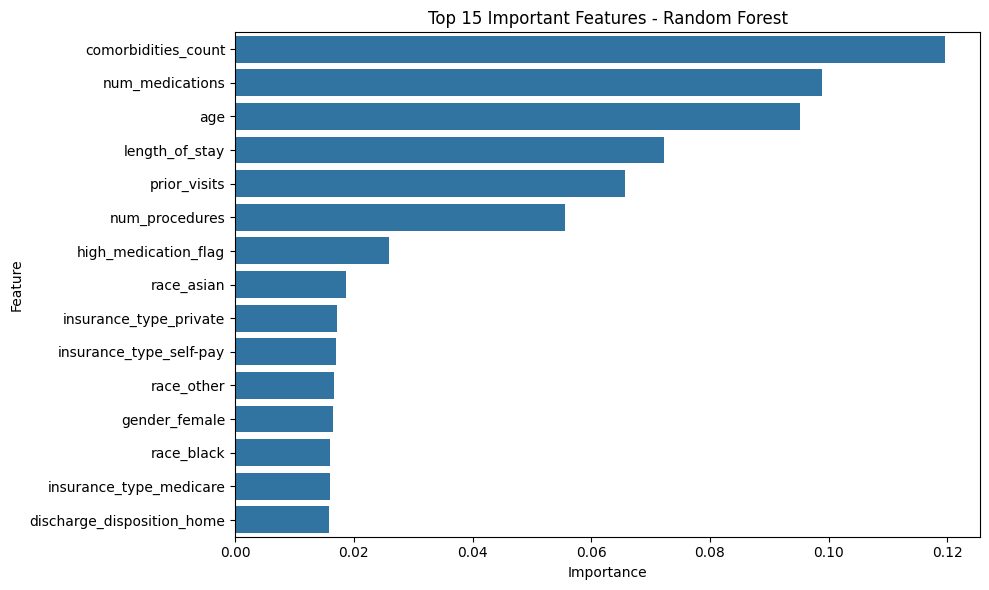

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df.head(15))
plt.title("Top 15 Important Features - Random Forest")
plt.tight_layout()
plt.show()


In [19]:
# Step 6: Model Explainability with SHAP

!pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 546.9/546.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 48.5 MB/s eta 0:00:00a 0:00:01


In [23]:
import shap

In [33]:
# Fit and transform preprocessor
preprocessor.fit(X_train)
X_train_transformed = preprocessor.transform(X_train)

# Convert to dense matrix (SHAP needs dense format)
if hasattr(X_train_transformed, 'toarray'):
    X_dense = X_train_transformed.toarray()
else:
    X_dense = X_train_transformed

# Get full feature names
cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(cat_names)


In [35]:
from sklearn.ensemble import RandomForestClassifier

# Train standalone RandomForest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_dense, y_train)


RandomForestClassifier(random_state=42)

In [53]:
import shap

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer(X_dense, check_additivity=False)


 98%|===================| 1562/1600 [00:15<00:00]        

<Figure size 640x480 with 0 Axes>

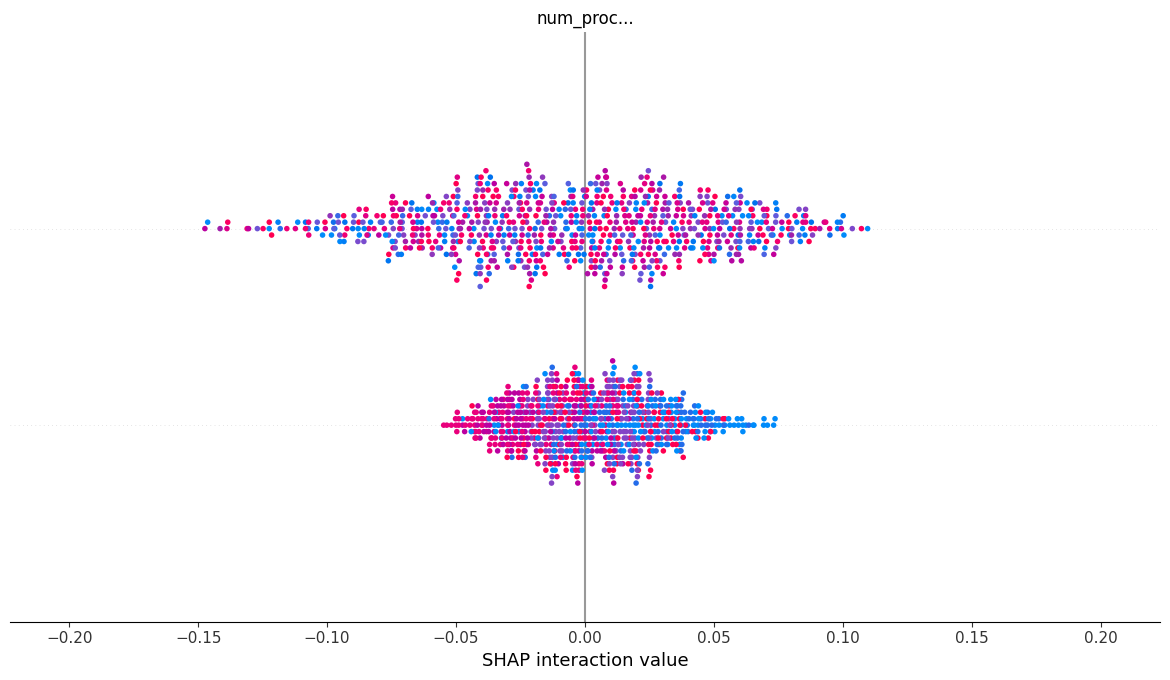

In [55]:
import shap
from shap import Explainer
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Refit and transform
preprocessor.fit(X_train)
X_train_transformed = preprocessor.transform(X_train)
X_dense = X_train_transformed.toarray() if hasattr(X_train_transformed, 'toarray') else X_train_transformed

# Feature names
cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(cat_names)

# Train RF
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_dense, y_train)

# Unified SHAP API with check_additivity=False
explainer = shap.Explainer(rf_model, X_dense)
shap_values = explainer(X_dense, check_additivity=False)

# Plot
shap.summary_plot(shap_values, feature_names=all_feature_names)


The number of procedures has a modest but generally low influence on readmission risk. Higher procedure counts tend to increase the likelihood of readmission slightly.

<Figure size 640x480 with 0 Axes>

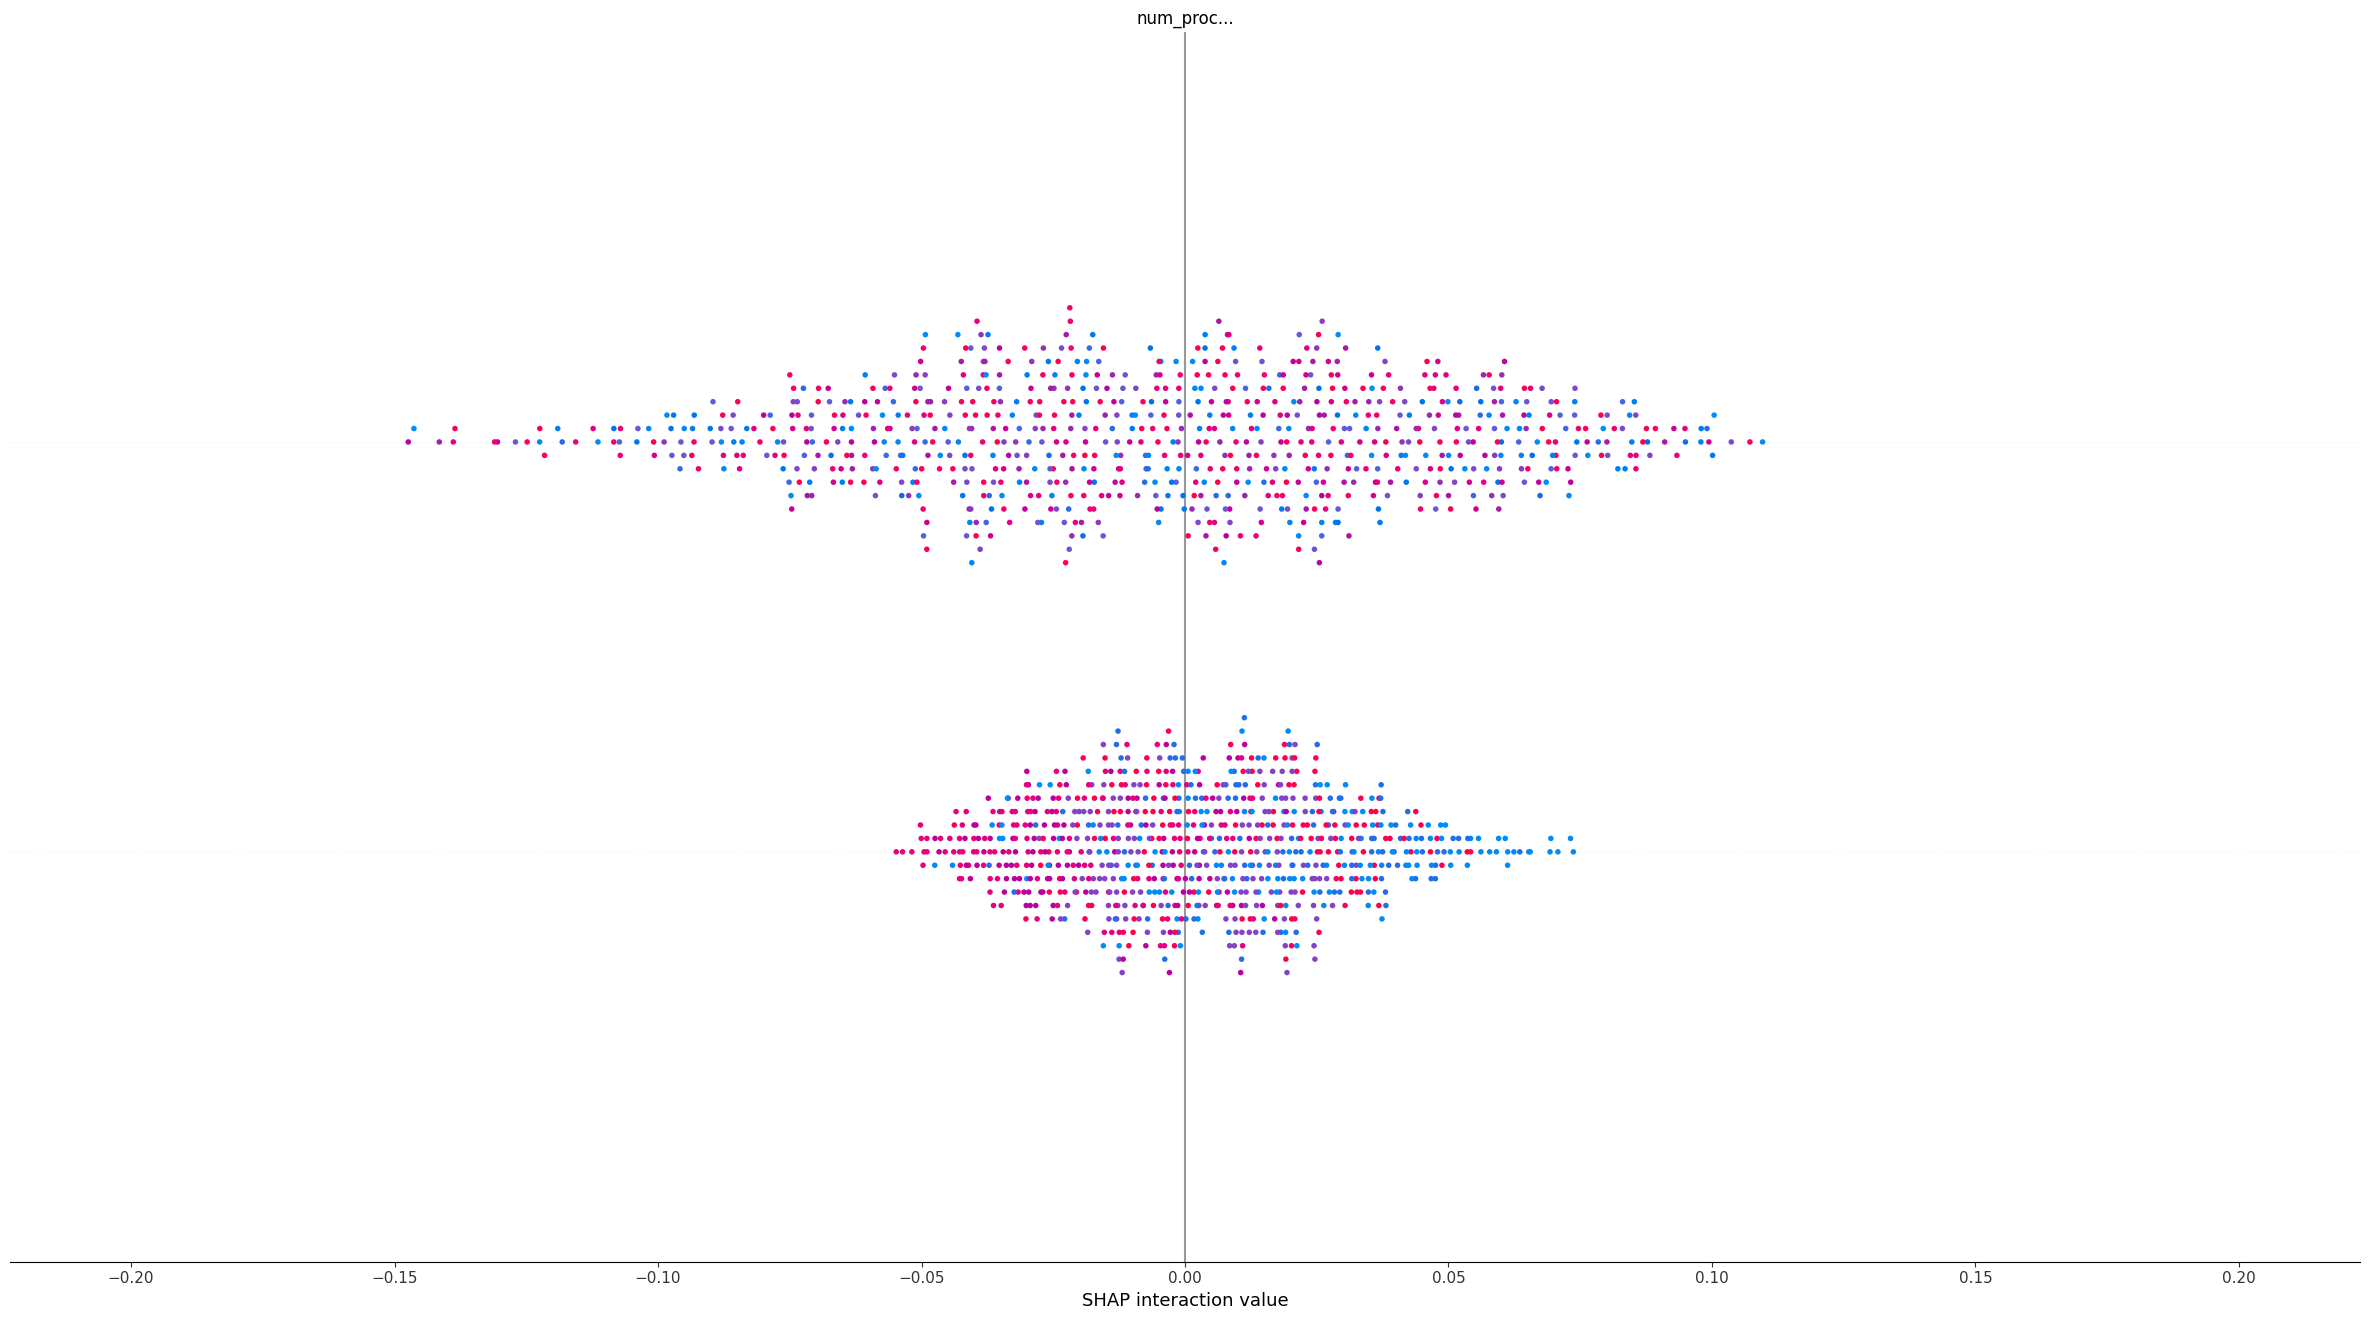

In [57]:
shap.summary_plot(shap_values, feature_names=all_feature_names, max_display=15)
